# Self supervised Learning

Pretrain a "foundation model" using data without outcomes, from a large unlabeled dataset. Note that the idea behind the pre-training is to guide the fine tunning task (survival prediction). **Note that given this is a toy example the pre-training effect may be marginal.** 

The input to the mode are the features from the dataset and **not the outcomes**

**Note that this notebook may take a while to complete when number of epochs is large**: For self supervised learning it is recommended to use a large  number of epochs. For illustration, we ran it for 1,000 epochs. 

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/home/shenwanxiang/anaconda3"
import tensorflow as tf
tf.test.is_gpu_available()
tf.__version__

2025-08-12 19:06:49.252244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-12 19:06:49.252399: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-12 19:06:49.252462: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-12 19:06:49.252554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-12 19:06:49.252617: I tensorflow/compiler/xla/stream_executo

'2.11.0'

In [11]:
import sys
sys.path.append('../codeocean/environment/clinical_transformer/')

import pandas as pd
from collections import Counter

from xai.models.SimplifiedClinicalTransformer.Trainer import Trainer
from xai.losses.survival import cIndex_SigmoidApprox as cindex_loss
from xai.metrics.survival import sigmoid_concordance as cindex

from xai.models import Trainer
from xai.models import SelfSupervisedTransformer
from xai.models import OptimizedSelfSupervisedDataGenerator as SelfSupervisedDataGenerator

from xai.losses.selfsupervision.classifier_regression import CompositeLoss

In [12]:
from samecode.random import set_seed

## Parameters

In [13]:
max_features_percentile=100
test_size=0.1
mode='self-supervision'
learning_rate=0.0001
repetitions=1
epochs=2000
verbose=2
seed=0
embedding_size = 128
num_heads = 2
num_layers = 2

loss = CompositeLoss(feature_w=1, value_w=0.1) # Contribution of individual losses (predicts keys, values) 

In [14]:
data = pd.read_csv('./data/dataset-pretrain.data.csv')
features = data.columns[-44:].tolist()
features

['CANCER',
 'Bcell_general',
 'Memory_Bcell',
 'Naive_Bcell',
 'Plasma_cell',
 'CD4_Tcell',
 'CD8_Tcell',
 'Memory_Tcell',
 'Naive_Tcell',
 'Tcell_general',
 'Cytotoxic_Tcell',
 'Exhausted_Tcell',
 'Immune_checkpoint',
 'Treg',
 'NKcell',
 'Innate_lymphoid_cell',
 'cDC',
 'pDC',
 'Macrophage',
 'Monocyte',
 'Myeloid',
 'Granulocyte',
 'Mast',
 'Erythrocyte',
 'Platelet',
 'Stem',
 'Stroma',
 'Pericyte',
 'Fibroblast',
 'Endothelial',
 'Epithelial',
 'Mesothelial',
 'Adipocyte',
 'Hepatocyte',
 'Pancreatic',
 'Pneumocyte',
 'Apoptosis_pathway',
 'IFNg_pathway',
 'TGFb_pathway',
 'Cytokine',
 'Cell_proliferation',
 'TLS',
 'Genome_integrity',
 'Reference']

In [15]:
!rm -r ./results/runs/FoundationModel

/bin/sh: /home/shenwanxiang/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/sh)


In [16]:
set_seed(0)
outdir = './results/runs/FoundationModel/'

trainer = Trainer(
    out_dir = outdir,
    max_features_percentile=max_features_percentile,
    test_size=test_size,
    mode=mode,
    model=SelfSupervisedTransformer, 
    dataloader=SelfSupervisedDataGenerator,
    loss=loss,
    metrics=[]
)

trainer.setup_data(
    data, 
    discrete_features = [],
    continuous_features = features,
)

trainer.setup_model(
    embedding_size=embedding_size, 
    num_heads=num_heads, 
    num_layers=num_layers,
    learning_rate=learning_rate,
    batch_size_max = True,
    batch_size=10000, # This will take a batch with the size of the training / testing shape,
    save_best_only=False
)

trainer.fit(repetitions=repetitions, epochs=epochs, verbose=verbose, seed=seed)

INFO	2025-08-12 19:06:49,548	Setting up working directory: ./results/runs/FoundationModel/
INFO	2025-08-12 19:06:49,549	Number of continuous features: 44
INFO	2025-08-12 19:06:49,550	Number of discrete features: 0
INFO	2025-08-12 19:06:49,550	Number of samples: 10184
INFO	2025-08-12 19:06:49,562	Number of classes: 52
INFO	2025-08-12 19:06:49,562	RUN ID: fold-0_id-0
INFO	2025-08-12 19:06:49,563	RUN ID out directory: ./results/runs/FoundationModel//fold-0_id-0/
INFO	2025-08-12 19:06:50,566	Training samples: 9165
INFO	2025-08-12 19:06:50,566	Testing samples: 1019
INFO	2025-08-12 19:06:50,589	Number of features at 100th percentile: 44 that are non nans


Epoch 1/2000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-12 19:06:50,990	AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fef40555680> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-12 19:06:54,323	AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7feb21c4fc20> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 - 4s - loss: 0.9586 - val_loss: 0.9149 - 4s/epoch - 4s/step
Epoch 2/2000
1/1 - 0s - loss: 0.9399 - val_loss: 0.8930 - 486ms/epoch - 486ms/step
Epoch 3/2000
1/1 - 0s - loss: 0.9242 - val_loss: 0.8776 - 481ms/epoch - 481ms/step
Epoch 4/2000
1/1 - 0s - loss: 0.9112 - val_loss: 0.8605 - 471ms/epoch - 471ms/step
Epoch 5/2000
1/1 - 0s - loss: 0.8990 - val_loss: 0.8427 - 482ms/epoch - 482ms/step
Epoch 6/2000
1/1 - 0s - loss: 0.8870 - val_loss: 0.8250 - 477ms/epoch - 477ms/step
Epoch 7/2000
1/1 - 0s - loss: 0.8767 - val_loss: 0.8113 - 476ms/epoch - 476ms/step
Epoch 8/2000
1/1 - 0s - loss: 0.8657 - val_loss: 0.7978 - 477ms/epoch - 477ms/step
Epoch 9/2000
1/1 - 0s - loss: 0.8600 - val_l

In [19]:
from xai.models import clean_run

clean_run(
    path='./results/runs/FoundationModel/',
    keep=[1, 10, 100, 500, 1000,1500,2000]
)

Processing: ./results/runs/FoundationModel/


Text(0, 0.5, 'SSL loss')

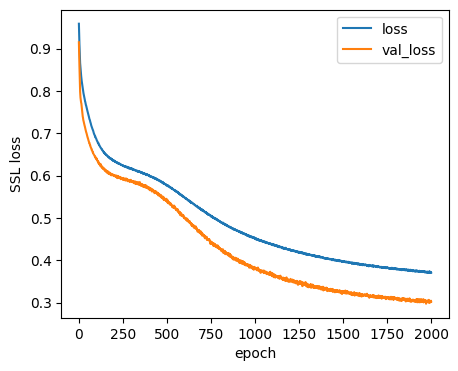

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

dfh = pd.read_csv("./results/runs/FoundationModel//fold-0_id-0/history.csv", index_col=0)
fig, ax=plt.subplots(figsize=(5,4))
dfh.plot(ax=ax)
ax.set_ylabel('SSL loss')